Specifically we will do how to work with ROC curves, strategies to handle imbalanced datasets, and why the end metric that you’re actually interested in should be considered during model selection (i.e., you should think beyond just accuracy and classification statistics).  
Specifically, we will:
- Apply and interpret an ROC curve on a logistic classifier on the Titanic Dataset 
- Fit a logistic regression model to a (simulated) dataset of past customer purchases, and see if we can predict whether they’re pregnant
- Build a classifier to predict cancer cases, and discover that overall prediction accuracy is often only part of the story in real life

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import metrics, datasets
import statsmodels.formula.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Let’s start by load in the Titanic Dataset and fit a standard logistic regression classifier.

In [6]:
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [7]:
titanic = titanic[['sex', 'age', 'class', 'survived']]
titanic.columns = ['sex', 'age', 'pclass', 'survived']
titanic = titanic.dropna()
is_female = pd.get_dummies(titanic.sex)['female']
pclass_coded = pd.get_dummies(titanic.pclass)[['First','Second']]
titanic_final = pd.concat([is_female,pclass_coded,titanic[['age','survived']]],axis=1)
titanic_final.head()

,female,First,Second,age,survived
0,0,0,0,22.0,0
1,1,1,0,38.0,1
2,1,0,0,26.0,1
3,1,1,0,35.0,1
4,0,0,0,35.0,0


In [8]:
titanic_final.survived.value_counts()

0    424
1    290
Name: survived, dtype: int64

In [9]:
log_model = LogisticRegression(C = 1000000)

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_final.drop('survived',axis = 1),titanic_final['survived'], test_size=0.2, random_state=123)

In [17]:
log_model.fit(X_train,y_train)

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [18]:
log_model.coef_

array([[ 2.66233164,  2.5962139 ,  1.13821077, -0.03594795]])

In [19]:
log_model.intercept_

array([-1.35329422])

In [20]:
y_pred_test = log_model.predict_proba(X_test)[:,1]

In [21]:
fpr,tpr,thresholds = metrics.roc_curve(y_test,y_pred_test)

In [24]:
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.81362889983579645

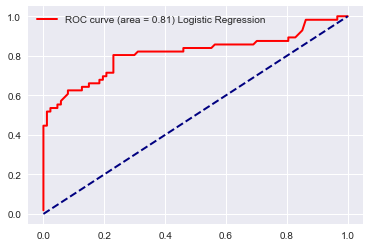

In [31]:
plt.plot(fpr, tpr, color='red',
         lw=2, label='ROC curve (area = %0.2f) Logistic Regression' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()

What does the red line actually mean in this scenario? How might our model be different if we were at a different position on the line?

In [37]:
#for 0.5 threshold
y_predicted = 0.5 < pd.DataFrame(log_model.predict_proba(X_test[['female','First','Second','age']]))[1]
print(metrics.classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

          0       0.80      0.79      0.80        87
          1       0.68      0.70      0.69        56

avg / total       0.76      0.76      0.76       143



In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted)

array([[69, 18],
       [17, 39]])

we can vary the threshold and prediction got much more accurate see below

In [39]:
#for 0.7 Threshold
y_predicted = 0.7 < pd.DataFrame(log_model.predict_proba(X_test[['female','First','Second','age']]))[1]
print(metrics.classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

          0       0.77      0.95      0.85        87
          1       0.89      0.55      0.68        56

avg / total       0.81      0.80      0.78       143



In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predicted)

array([[83,  4],
       [25, 31]])

Per the precision stats above, our model is getting about 3/4 of the test set correctly categorized, but still has a lot of false negatives and false positives.

we need to vary this threshold based on our requirment.it is a very big mistake to predict cancer patient as not cancer so in this case we need to decrese False Negatives. so as per our need we need to tune our model.

Now suppose we wanted our FPR to be set at most at 0.3. What is the highest TPR we can get and  What is the threshold at that point. we can get this by below

In [45]:
print("Highest TPR with FPR set at 0.3: ", tpr[np.min([i for i, x in enumerate(fpr) if x>=0.3])])
print("Corresponding Threshold: ",thresholds[np.min([i for i, x in enumerate(fpr) if x>=0.3])])

Highest TPR with FPR set at 0.3:  0.821428571429
Corresponding Threshold:  0.289442234877


##### Review oversampling

This dataset was adapted from an example in Data Smart by John Foreman. It's a dataset of indicator variables about customer purchases in the past six-months for a (simulated) large retailer. Ala the scandal that Target experienced a few years back, the question is, can you predict customer’s pregnancy status based on their purchases alone?

In [123]:
data_train = pd.read_csv("store_data_train.csv")
data_test = pd.read_csv("store_data_test.csv")
data_train.head()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes,PREGNANT
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [47]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
Pregnancy Test         1000 non-null int64
Birth Control          1000 non-null int64
Feminine Hygiene       1000 non-null int64
Folic Acid             1000 non-null int64
Prenatal Vitamins      1000 non-null int64
Prenatal Yoga          1000 non-null int64
Body Pillow            1000 non-null int64
Ginger Ale             1000 non-null int64
Sea Bands              1000 non-null int64
Cigarettes             1000 non-null int64
Smoking Cessation      1000 non-null int64
Stopped buying wine    1000 non-null int64
Wine                   1000 non-null int64
Maternity Clothes      1000 non-null int64
PREGNANT               1000 non-null int64
dtypes: int64(15)
memory usage: 117.3 KB


In [48]:
data_train.describe()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes,PREGNANT
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.075000,0.140000,0.141000,0.106000,0.128000,0.018000,0.018000,0.069000,0.030000,0.097000,0.060000,0.130000,0.123000,0.131000,0.50000
std,0.263523,0.347161,0.348196,0.307992,0.334257,0.133018,0.133018,0.253581,0.170673,0.296106,0.237606,0.336472,0.328602,0.337569,0.50025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.50000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [50]:
data_train.groupby('PREGNANT').count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,500,500,500,500,500,500,500,500,500,500,500,500,500,500
1,500,500,500,500,500,500,500,500,500,500,500,500,500,500


In [51]:
data_test.groupby('PREGNANT').count()

,Pregnancy Test,Birth Control,Feminine Hygiene,Folic Acid,Prenatal Vitamins,Prenatal Yoga,Body Pillow,Ginger Ale,Sea Bands,Cigarettes,Smoking Cessation,Stopped buying wine,Wine,Maternity Clothes
PREGNANT,,,,,,,,,,,,,,
0,940,940,940,940,940,940,940,940,940,940,940,940,940,940
1,60,60,60,60,60,60,60,60,60,60,60,60,60,60


Note that only ~4% of adult women are pregnant at any given time, so it’s a very imbalanced classification problem. However, i’ve significantly oversampled observations of pregnant women in our training data so as to ensure that our model does a good job of identifying true positives.

In [52]:
log_model_imb = LogisticRegression(C=1000000)

In [53]:
log_model_imb.fit(data_train.drop('PREGNANT',axis =1),data_train['PREGNANT'])

LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [54]:
log_model_imb.score(data_test.drop('PREGNANT',axis =1),data_test['PREGNANT'])

0.88700000000000001

In [61]:
y_prediction_proba = log_model_imb.predict_proba(data_test.drop('PREGNANT',axis =1))[:,1]

In [62]:
fpr,tpr,thr = metrics.roc_curve(data_test['PREGNANT'],y_prediction_proba)

In [63]:
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.88559397163120557

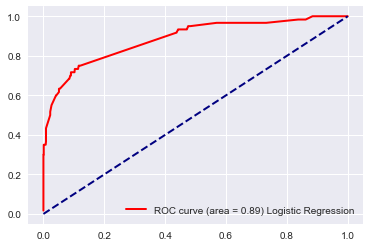

In [64]:
plt.plot(fpr, tpr, color='red',
         lw=2, label='ROC curve (area = %0.2f) Logistic Regression' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()

In [68]:
y_pred = log_model_imb.predict(data_test.drop('PREGNANT',axis =1))

In [70]:
conf_mat = metrics.confusion_matrix(data_test['PREGNANT'],y_pred)
conf_mat

array([[843,  97],
       [ 16,  44]])

In [71]:
print("True Positive Rate for Fitted: ", float(conf_mat[1][1])/(conf_mat[1][1]+ conf_mat[1][0]))
print("True Negative Rate for Fitted: ", float(conf_mat[0][0])/(conf_mat[0][0] + conf_mat[0][1]))
print("False Positive Rate for Fitted: ", float(conf_mat[0][1])/(conf_mat[0][1] + conf_mat[0][0]))

True Positive Rate for Fitted:  0.733333333333
True Negative Rate for Fitted:  0.896808510638
False Positive Rate for Fitted:  0.103191489362


Now suppose we wanted our FPR to be set at most at 0.3. What is the highest TPR we can get

In [72]:
print("Highest TPR with FPR set at 0.3: ", tpr[np.min([i for i, x in enumerate(fpr) if x>=0.3])])
print("Corresponding Threshold: ",thresholds[np.min([i for i, x in enumerate(fpr) if x>=0.3])])

Highest TPR with FPR set at 0.3:  0.916666666667
Corresponding Threshold:  0.234032793942



Note that while our model does a great job of identifying true-positives (pregnant women) it comes at the cost of increased false-positives. Depending on what we were actually going to do this data, we might prefer one or another, and build a model that chose a different optimum on the ROC curve.

#### Cancer Prediction with Dropping Missing Values and Mean Imputation

In [105]:
data = pd.read_csv('cancer_data.csv') 
data.head()

,Incidence,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
0,1,-0.00184,0.02440,1.090,0.948,NaN,-1.560,-1.580,-0.664,0.568,-0.4590,-1.200,0.0957,-0.210,-0.72900,0.575,NaN
1,1,-0.04980,0.00719,1.070,0.923,0.472,-1.690,-1.650,0.594,0.205,-0.2810,-1.280,-0.1140,-0.147,0.36300,1.070,1.460
2,1,-0.12000,0.00218,0.141,0.140,0.288,-0.428,-0.538,NaN,-0.433,0.1690,-0.678,-0.7380,0.271,0.78800,0.779,0.389
3,1,-0.11600,0.08790,0.324,0.277,0.399,-0.336,-0.336,NaN,-0.168,0.2120,-0.689,0.5580,0.188,-0.00104,0.178,0.546
4,1,-0.06150,-0.26000,0.871,0.755,NaN,-1.430,-1.390,-0.796,-0.422,-0.0827,-1.380,-0.0306,0.605,NaN,NaN,NaN


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 17 columns):
Incidence    15474 non-null int64
X1           15474 non-null float64
X2           15474 non-null float64
X3           15474 non-null float64
X4           15474 non-null float64
X5           12998 non-null float64
X6           15474 non-null float64
X7           15474 non-null float64
X8           13027 non-null float64
X9           15474 non-null float64
X10          15474 non-null float64
X11          15474 non-null float64
X12          15474 non-null float64
X13          15474 non-null float64
X14          13061 non-null float64
X15          13074 non-null float64
X16          13046 non-null float64
dtypes: float64(16), int64(1)
memory usage: 2.0 MB


In [77]:
data.isnull().sum()

Incidence       0
X1              0
X2              0
X3              0
X4              0
X5           2476
X6              0
X7              0
X8           2447
X9              0
X10             0
X11             0
X12             0
X13             0
X14          2413
X15          2400
X16          2428
dtype: int64

In [78]:
data_wonan = data.copy()
data_wonan = data_wonan.dropna()

In [81]:
X_train, X_test, y_train, y_test = train_test_split(data_wonan.drop('Incidence',axis = 1),data_wonan['Incidence'],test_size=0.3, random_state=42)

In [82]:
log_cancer = LogisticRegression(C=10)

In [84]:
log_cancer.fit(X_train,y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
#Test score
log_cancer.score(X_test,y_test)

0.99085830370746575

In [86]:
#Train Score
log_cancer.score(X_train,y_train)

0.99107531562908147

In [87]:
y_pred = log_cancer.predict(X_test)

In [91]:
conf_mat = metrics.confusion_matrix(y_test,y_pred)
conf_mat

array([[1947,    0],
       [  18,    4]])

In [92]:
print("True Positive Rate for Fitted: ", float(conf_mat[1][1])/(conf_mat[1][1]+ conf_mat[1][0]))
print("True Negative Rate for Fitted: ", float(conf_mat[0][0])/(conf_mat[0][0] + conf_mat[0][1]))
print("False Positive Rate for Fitted: ", float(conf_mat[0][1])/(conf_mat[0][1] + conf_mat[0][0]))

True Positive Rate for Fitted:  0.181818181818
True Negative Rate for Fitted:  1.0
False Positive Rate for Fitted:  0.0


In [94]:
y_test.sum()

22

We can see that prediction accuracy is only part of the story. Most of the high predictive power is due to predicting the negative cases. We perform very bad for the positive case, with only 4 right prediction of Cancer out of 22.

##### Mean Imputation

In [106]:
from sklearn.preprocessing import Imputer

In [107]:
imputer = Imputer( strategy='mean')
data = imputer.fit_transform(data.values)

In [108]:
data = pd.DataFrame(data)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(0,axis = 1),data[0],test_size=0.3, random_state=42)

In [115]:
log_cancer_imp = LogisticRegression(C=10)

In [116]:
log_cancer_imp.fit(X_train,y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [117]:
#Test score
log_cancer_imp.score(X_test,y_test)

0.99073874650010774

In [118]:
#Train score
log_cancer_imp.score(X_train,y_train)

0.99067491459699009

In [119]:
y_pred = log_cancer_imp.predict(X_test)

In [120]:
conf_mat = metrics.confusion_matrix(y_test,y_pred)
conf_mat

array([[4591,    2],
       [  41,    9]])

In [121]:
print("True Positive Rate for Fitted: ", float(conf_mat[1][1])/(conf_mat[1][1]+ conf_mat[1][0]))
print("True Negative Rate for Fitted: ", float(conf_mat[0][0])/(conf_mat[0][0] + conf_mat[0][1]))
print("False Positive Rate for Fitted: ", float(conf_mat[0][1])/(conf_mat[0][1] + conf_mat[0][0]))

True Positive Rate for Fitted:  0.18
True Negative Rate for Fitted:  0.999564554757
False Positive Rate for Fitted:  0.000435445242761


This does a bit better than before, but still missed a ton of cases for the positives!